In [1]:
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import numpy as np

####
# Define constants
###


### all parameters taken from cerevisiae


#Transcription:
# Pelechano, V., Chávez, S., & Pérez-Ortín, J. E. (2010). A complete set of nascent transcription rates for yeast genes. PloS one, 5(11), e15442.
# average transcription rate of 0.12 molecules/min. we take a higher number as AOX promoter should be highly induced under methanol condition. in the study peroxisomal gene CIT2 was transcribed at 1 molecule/min
# rna-seq data from phaffii reveals that it is highly transcribed; 85* higher number of reads (normalized) than average. we take 85 * 0.12 = 10.2 it seems too high. the highest observed in the pelechano study was 7.5, so 5 molecules/min might be good guess 

ktx = 1/12     #M/s maximum transcription rate


# Bonven B, Gulløv K. Peptide chain elongation rate and ribosomal activity in Saccharomyces cerevisiae as a function of the growth rate. Mol Gen Genet. 1979 Feb 26 170(2):225-30
# numer of nucleotides is 481 --> (481/3)/7.5 (7.5 is "medium" value from paper for AA elongation per second) --> translation per second 
# Riba, A., Di Nanni, N., Mittal, N., Arhné, E., Schmidt, A., & Zavolan, M. (2019). Protein synthesis rates and ribosome occupancies reveal determinants of translation elongation rates. Proceedings of the national academy of sciences, 116(30), 15023-15032.
# in the second paper, ribosomes per codon and protein synthesis rates are considered. it is quite clear that one can expect a ribosome every 10-100 codons. they state the AA/s rate as ranging from 1-20, so we will keep 7.5 and simulate with 5 ribosomes per transcript as a conservative guess and within their average rates. 

ktl =  4.6e-2*5               #M/s maximum translation constant


#Brandon Ho et al., Comparative analysis of protein abundance studies to quantify the Saccharomyces cerevisiae proteome, bioRxiv preprint first posted online Feb. 2, 2017
# they specified typical half-life at 32 min, so we took 30 minutes=1800 seconds to calculate decay per second

deg_mRNA = 1.7e-4        #/s degredation constant of mRNA

# Christiano R, Nagaraj N, Fröhlich F, Walther TC. Global proteome turnover analyses of the Yeasts S. cerevisiae and S. pombe. Cell Rep. 2014 Dec 11 9(5):1959-65. doi: 10.1016/j.celrep.2014.10.065. Supplemental Information p.S12 table S4
# 
# average and median half life is 43 min according to : Belle A, Tanay A, Bitincka L, Shamir R, O'Shea EK. Quantification of protein half-lives in the budding yeast proteome. Proc Natl Acad Sci U S A. 2006 Aug 29 103(35):13004-9 p.13004 right column 4th paragraph

# as hemoglobin is big and fulfils important function, it could have longer half life, like that of the ones with high half life defined in paper by christiano et al.
# so 5hrs = 18000s are taken ### we could look up the half life of our particular hemoglobin further

deg_Protein = 1.67e-5      #/s degredation constant of Protein

In [2]:

# helper function to get methanol/glucose depending on time

methanol_induction = 36000

def methanol_time(m,t):
    return m if t>methanol_induction else 0

# Jordà, J., Jouhten, P., Cámara, E. et al. Metabolic flux profiling of recombinant protein secreting Pichia pastoris growing on glucose:methanol mixtures. Microb Cell Fact 11, 57 (2012). https://doi.org/10.1186/1475-2859-11-57
# considering glucose consupmtion of 0.76 mmol/gDWh as observed in this paper when fed on 80%/20% methanol



# as it is a molar solution concentration the cell dry weight per liter has to be taken into consideration when calculation the absolute consumption
# here it is stated that they and others have reached dry cell weights of more than 100 g/L, we take 100
# --> 0.76 mmol/gDWh === 76 mmol/Lh === ca. 21 nanomol/Ls 

def glucose_fade(g,t):
    elapsed = t - methanol_induction
    return(g-elapsed*21 if (g-elapsed*21)>0 else 0)

def glucose_time(g,t):
    return g if t<methanol_induction else glucose_fade(g,t)



In [3]:
###
#Define ODE
###

def ODEs(variables, t, methanol):
    #variables = list of concentrations, so here, [mRNA , Protein]. t = time
    mRNA = variables[0] 
    Protein = variables[1]  #
    #hill_coefficient_MXR1_methanol = 1.539 
    hill_coeff_AOX_methanol = 10#1.539 # mxr1 and mit1, prm without competition according to Wang, X., Wang, Q., Wang, J., Bai, P., Shi, L., Shen, W., ... & Cai, M. (2016). Mit1 transcription factor mediates methanol signaling and regulates the alcohol oxidase 1 (AOX1) promoter in Pichia pastoris. Journal of Biological Chemistry, 291(12), 6245-6261.
    
    # Kumar, N. V., & Rangarajan, P. N. (2012). The zinc finger proteins Mxr1p and repressor of phosphoenolpyruvate carboxykinase (ROP) have the same DNA binding specificity but regulate methanol metabolism antagonistically in Pichia pastoris. Journal of biological chemistry, 287(41), 34465-34473.
    # this paper describes mxr1 Kd bound to AOX promoter at 200 nM
    
    # Tschopp, J. F., Brust, P. F., Cregg, J. M., Stillman, C. A., & Gingeras, T. R. (1987). Expression of the lacZ gene from two methanol-regulated promoters in Pichia pastoris. Nucleic acids research, 15(9), 3859-3876.
    # this paper uses 0.5% methanol and gives a rough time course of aox activation
    # Santoso, A., Herawati, N., & Rubiana, Y. (2012). Effect of methanol induction and incubation time on expression of human erythropoietin in methylotropic yeast Pichia pastoris. Makara Journal of Technology, 16(1), 5.
    # this paper found that at 2.5% methanol, cell growth is optimal. they tried out different levels and measured aox expression but did not provide data
    # Van Dijken, L. P., Otto, R., & Harder, W. (1976). Growth of Hansenula polymorpha in a methanol-limited chemostat. Archives of microbiology, 111(1), 137-144.
    # this paper describes the oxygen consumption rates at 3 different levels of methanol. might be a usable indirect measurement of the methanol oxidation activity and therefore AOX presence


    Km_AOX = 200 #nM
    methanol_concentration = methanol_time(methanol,t) #mM
    # functionn to model to activity level of gene transcription depending on TF concentration
    #hill_eq_MXR1_vs_methanol = methanol_concentration**hill_coefficient_MXR1_methanol/(K**hill_coefficient_MXR1_methanol+methanol_concentration**hill_coefficient) #nM we can vary TF and so indirectly methanol here
    
    # Couderc, R., & Baratti, J. (1980). Oxidation of methanol by the yeast, Pichia pastoris. Purification and properties of the alcohol oxidase. Agricultural and biological chemistry, 44(10), 2279-2289.
    # this paper gives 1.4 mM as methanol Km for AOX activity on 0.19 mM O2 and 3.1 mM at 0.93 mM O2
    #Km_AOX = 3.1 #mM, alternatively 3.1 at higher O2
    hill_eq_AOX_vs_methanol = methanol_concentration**hill_coeff_AOX_methanol/(Km_AOX**hill_coeff_AOX_methanol+methanol_concentration**hill_coeff_AOX_methanol)


# arbitrary numbers, try so that concentration is just a little above Kd (steep curve will make it big fast)

    coef_repr = 10
    K_repressor = 50
    conc_repr = glucose_time(2000,t)
    repressor = K_repressor**coef_repr/(K_repressor**coef_repr+conc_repr**coef_repr)

    leakiness = 0.0000001



    # RNA
    
    yeast_weight = 4.6e-11 # g 
    max_Hemo = 0.05*yeast_weight/2.65686246e-20 # g molecules/yeast cell, corresponding to 10% of cell protein
    factor = 10
    bound_term = max_Hemo**factor/(max_Hemo**factor+Protein**factor)

    dmRNA_dt =       leakiness*ktx + (1-leakiness)*repressor*ktx*hill_eq_AOX_vs_methanol - deg_mRNA*mRNA
    
    # Protein
 
    dProtein_dt =   bound_term*ktl*mRNA - deg_Protein*Protein

    return [dmRNA_dt, dProtein_dt] 



<ipython-input-8-35c6b813765f>:9: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  t = sp.linspace(t0,t1,total)                       #set the array of time values to integrate over


108000.0


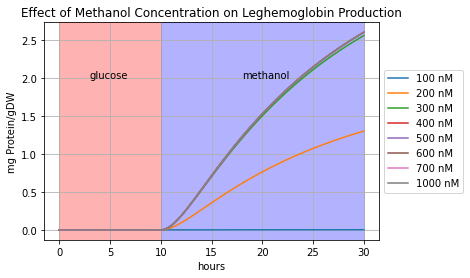

In [8]:
#####
#Solving the ODEs
#####
t0 = 0              #Initial time
t1 = 108000       #Final time
total =  10000    #Number of time steps (larger the better)

initial_conditions = [0.0, 0.0]        #set the initial values for [mRNA] and [Protein]
t = sp.linspace(t0,t1,total)                       #set the array of time values to integrate over
print(t[-1])

methanol_concentrations = [100,200,300,400,500,600,700,1000]
bib=dict()
for i in range(len(methanol_concentrations)):
    solution = odeint(ODEs , initial_conditions , t, (methanol_concentrations[i],)) #Produces an 2d array of solutions
                                                     #for each variable wrt time
    mRNA = solution[:,0]    #Index all values in first column
    Protein = solution[:,1] #Index all values in second column
      
        
    # yeast dry weight: https://tipbiosystems.com/wp-content/uploads/2020/05/AN102-Yeast-Cell-Count_2019_03_17.pdf
    # specifically dry weight

        
    yeast_weight = 4.6e-11 # g 


    Protein = Protein*2.65686246e-20*(1/yeast_weight)*1000
    bib["Protein_{}".format(i)] = Protein


    plt.plot(t/60/60, bib["Protein_{}".format(i)], label="{} nM".format(methanol_concentrations[i]))
    
#####
#Plot the data
#####


    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axvspan(0,methanol_induction/60/60,color='red',alpha=0.3)
plt.axvspan(methanol_induction/60/60,t[-1]/60/60,color='blue',alpha=0.3)
plt.text((methanol_induction/60/60/2)-2,2,'glucose')
plt.text((t[-1]-methanol_induction)/60/60-2,2,'methanol')
plt.title("Effect of Methanol Concentration on Leghemoglobin Production")
plt.xlabel("hours")
plt.ylabel("mg Protein/gDW")
plt.grid()
plt.show()
